In [1]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

In [2]:
path = untar_data(URLs.ESC50, dest="demo/ESC50")

TypeError: untar_data() got an unexpected keyword argument 'dest'

In [ ]:
(path/"audio").ls()

In [4]:
(path/"meta").ls()

(#2) [Path('demo/ESC50/master/meta/esc50-human.xlsx'),Path('demo/ESC50/master/meta/esc50.csv')]

In [5]:
df = pd.read_csv(path/"meta"/"esc50.csv")
df.head()

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

In [6]:
# Helper function to split the data
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [7]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

/home/skander/.cache/pypoetry/virtualenvs/ml-L4gBokpX-py3.9/lib/python3.9/site-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [8]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref=path/"audio"), 
                 splitter = CrossValidationSplitter(fold=1),
                 batch_tfms = [a2s],
                 get_y = ColReader("category"))

In [9]:
dbunch = auds.dataloaders(df, bs=64)

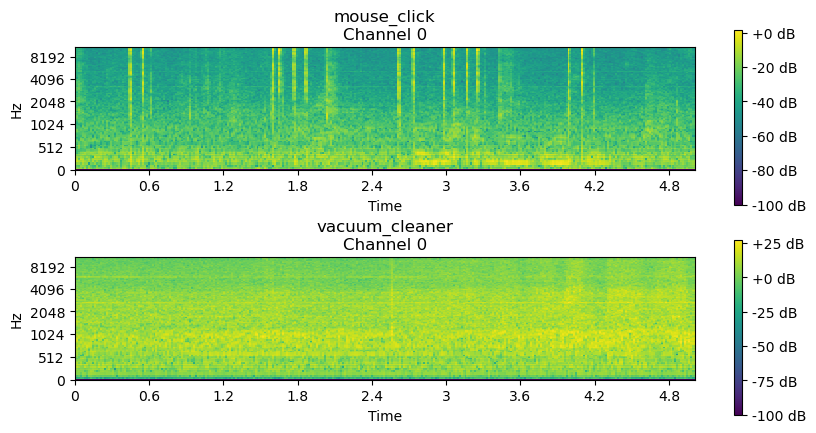

In [10]:
dbunch.show_batch(figsize=(10, 5))

In [11]:
learn = cnn_learner(dbunch, 
            resnet18,
            n_in=1,  # <- This is the only audio specific modification here
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/skander/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
@skip_if_ci
def run_learner():
    # epochs are a bit longer due to the chosen melspectrogram settings
    learn.fine_tune(10)

In [14]:
run_learner()

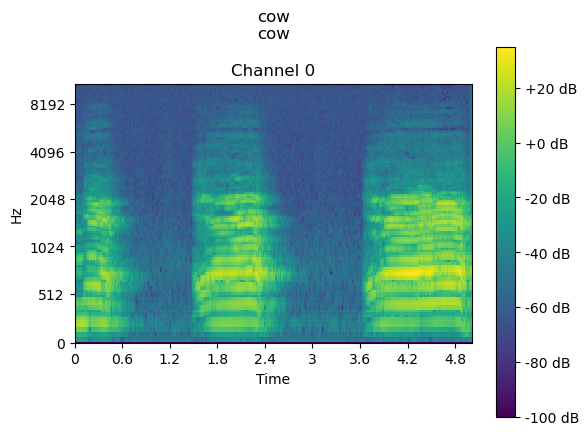

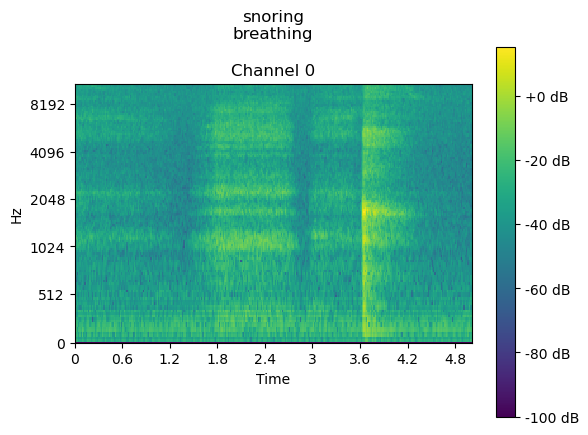

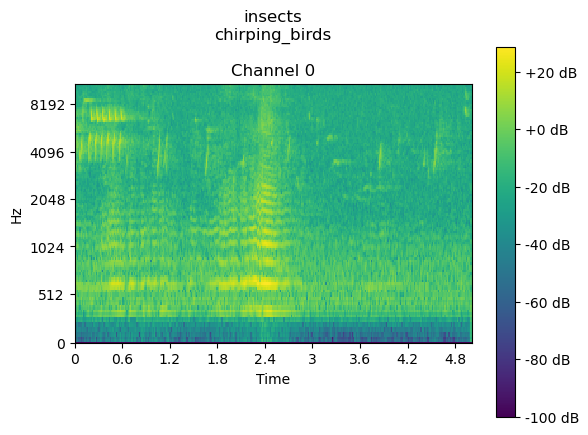

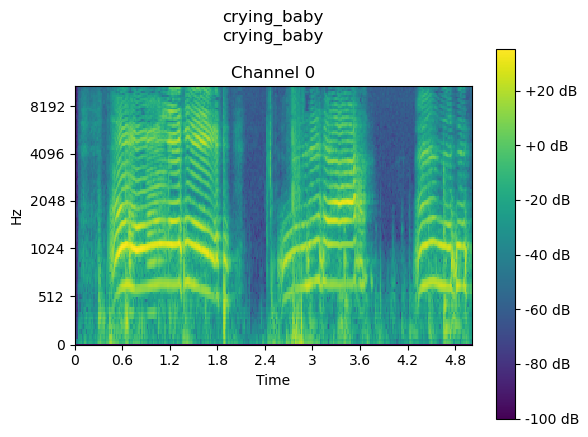

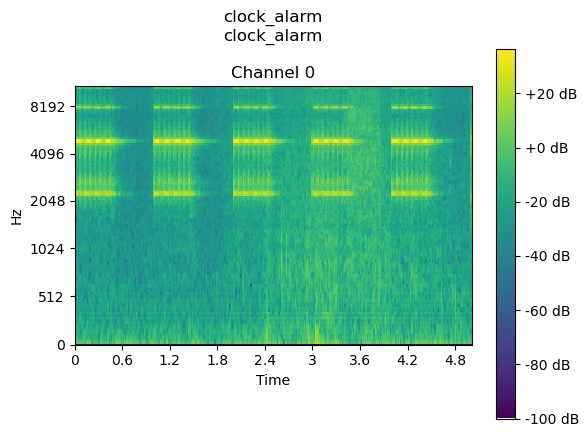

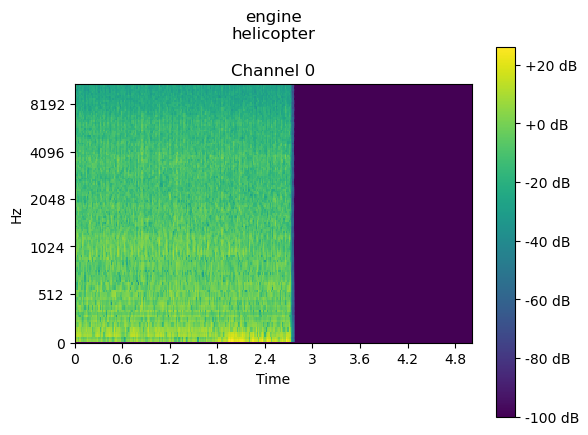

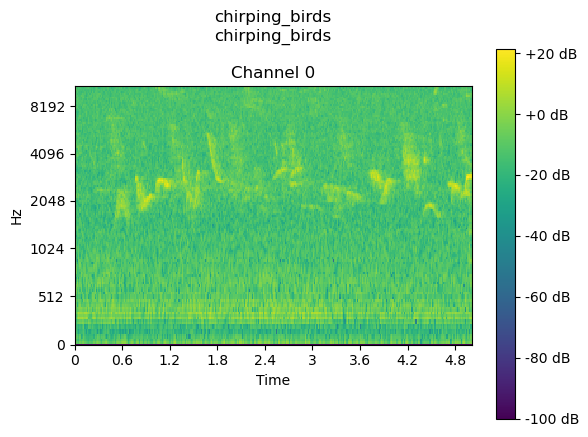

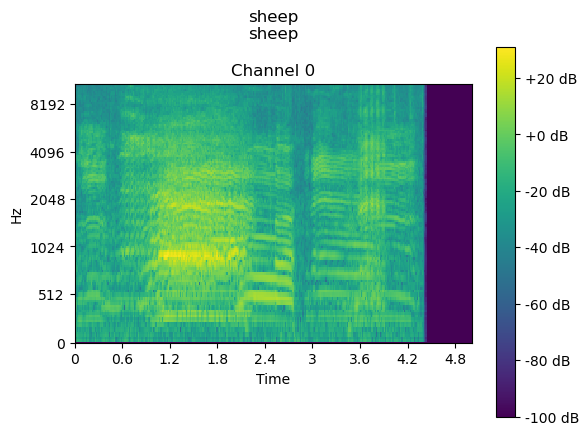

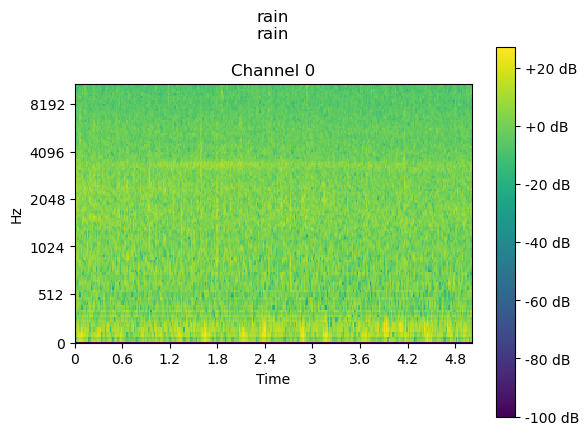

In [15]:
learn.show_results()